In [221]:
from scipy.io import arff
from operator import index

import numpy as np
from sklearn.neighbors import NearestNeighbors, KernelDensity
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from scipy.stats import gaussian_kde
import seaborn as sns
from sklearn import preprocessing
import math

from statsmodels.sandbox.panel.sandwich_covariance_generic import kernel

plt.rcParams['figure.figsize'] = [15, 7]

In [222]:
arff_file = arff.loadarff('./clusters/artificial/cluto-t4-8k.arff')
df = pd.DataFrame(arff_file[0])

In [223]:
df.head()

,x,y,CLASS
0,68.601997,102.491997,b'0'
1,454.665985,264.808990,b'2'
2,101.283997,169.285995,b'noise'
3,372.614990,263.140991,b'2'
4,300.989014,46.555000,b'5'


In [224]:
X = df.iloc[:,:2].values
y = df.iloc[:,2]
le = LabelEncoder()
y = le.fit_transform(y)

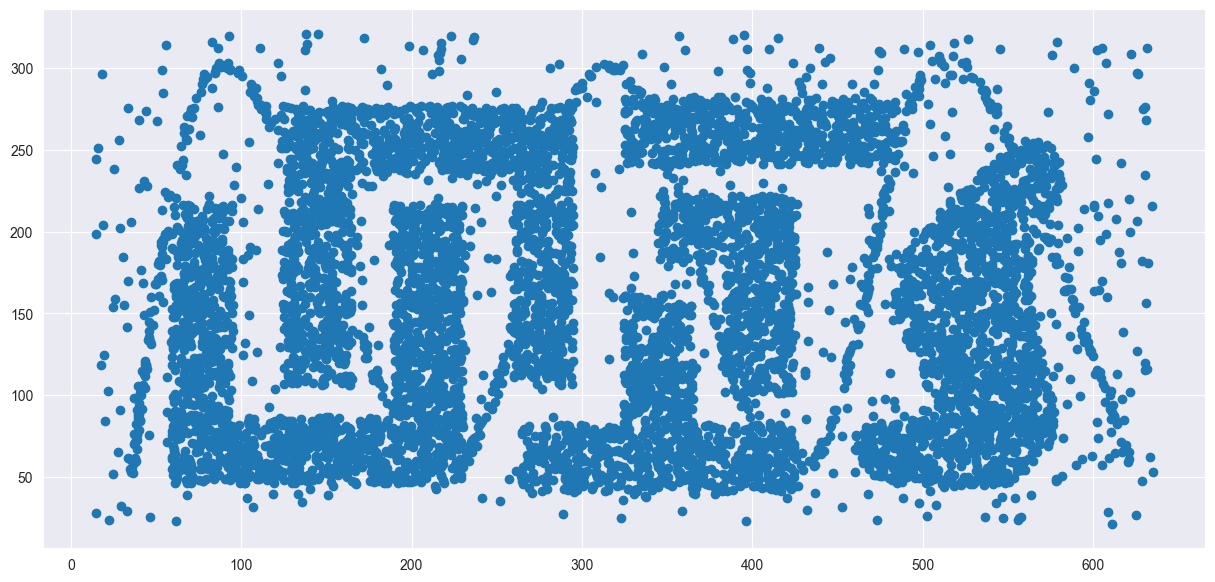

In [225]:
plt.scatter(X[:,0],X[:,1])

In [226]:
def main(X,y,n):
    nn = NearestNeighbors(n_neighbors=n)
    nn.fit(X)
    dist, knn = nn.kneighbors(X)  # returns N index neighbors including self
    return knn, dist

knn, distReturn = main(X,y,2)

In [227]:
def generateArr(newDist, median='median'):
    arr = []
    for x in newDist:  # finds the distance away from that point (index 0)
        if median == 'median':
            arr += [np.median(x)]
        elif median == 'sum': # min + median + max
            arr += [x[1]+np.max(x)+np.median(x)]
        elif median == 'max':
            arr += [np.max(x)]
        elif median == 'minMax':
            arr += [np.max(x)+x[1]]
        elif median == 'medMax':
            arr += [np.median(x)+np.max(x)]
        elif median == 'min':
            arr += [x[1]]
            

    return arr

distReturn = np.array(distReturn)
arr = generateArr(distReturn, median="max")

In [228]:
q3 = np.quantile(arr, 0.75)
spaced = np.linspace(50,100,num=300)
print(spaced)

[ 50.          50.16722408  50.33444816  50.50167224  50.66889632
  50.8361204   51.00334448  51.17056856  51.33779264  51.50501672
  51.6722408   51.83946488  52.00668896  52.17391304  52.34113712
  52.5083612   52.67558528  52.84280936  53.01003344  53.17725753
  53.34448161  53.51170569  53.67892977  53.84615385  54.01337793
  54.18060201  54.34782609  54.51505017  54.68227425  54.84949833
  55.01672241  55.18394649  55.35117057  55.51839465  55.68561873
  55.85284281  56.02006689  56.18729097  56.35451505  56.52173913
  56.68896321  56.85618729  57.02341137  57.19063545  57.35785953
  57.52508361  57.69230769  57.85953177  58.02675585  58.19397993
  58.36120401  58.52842809  58.69565217  58.86287625  59.03010033
  59.19732441  59.36454849  59.53177258  59.69899666  59.86622074
  60.03344482  60.2006689   60.36789298  60.53511706  60.70234114
  60.86956522  61.0367893   61.20401338  61.37123746  61.53846154
  61.70568562  61.8729097   62.04013378  62.20735786  62.37458194
  62.54180

3.248168886174396e-05
[3.527196896168348e-05, 3.6740916969848594e-05, 3.827949590235061e-05, 3.988945218905944e-05, 4.157244059175814e-05, 4.3330014316809775e-05, 4.5163615102062466e-05, 4.707456331320039e-05, 4.906404808676314e-05, 5.113311755908619e-05, 5.328266922244971e-05, 5.5513440451736e-05, 5.782599924686687e-05, 6.022073523819551e-05, 6.269785100383083e-05, 6.525735374955436e-05, 6.789904740350311e-05, 7.062252517912038e-05, 7.342716266097078e-05, 7.631211146884697e-05, 7.927629355612628e-05, 8.231839619853086e-05, 8.543686772926436e-05, 8.862991407591645e-05, 9.189549615350615e-05, 9.523132816654301e-05, 9.558008491474593e-05, 9.303590978821093e-05, 9.054770442999883e-05, 8.811546632294783e-05, 8.573910581427663e-05, 8.341845378047819e-05, 8.115326911096274e-05, 7.894324594674751e-05, 7.678802061708163e-05, 7.468717822387855e-05, 7.26402588310249e-05, 7.064676322302416e-05, 6.87061582048609e-05, 6.681788142238501e-05, 6.498134568981642e-05, 6.31959428180749e-05, 6.14610469444

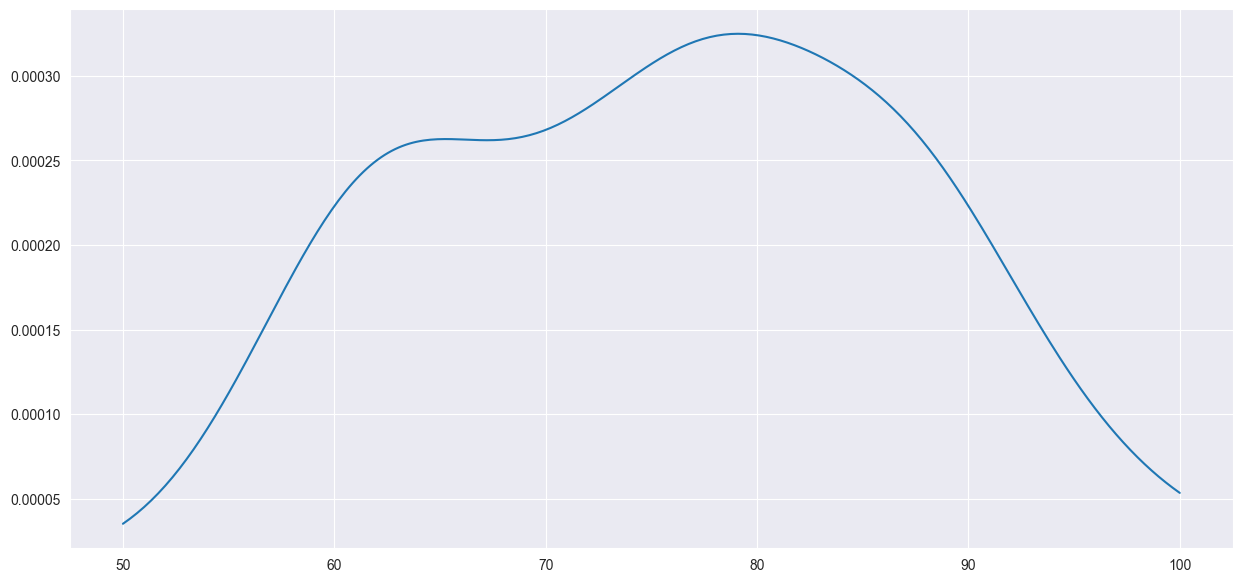

In [239]:
#density function
pdf = np.array([])
totalPdf = []
mean1 = np.mean(X[:,0])
mean2 = np.mean(X[:,1])
sigma = 3*q3

for a in range(X.shape[0]):
    for t in spaced:
        w = pow((t-X[a][0]),2)
        q = pow((t-X[a][1]),2)
        expTotal = -((w+q) / (2*pow(sigma,2)))
        e = math.exp(expTotal)
        bottom = (2*math.pi) * (pow(sigma,2))
        bottomR = 1 / bottom
        density = bottomR * e
        pdf = np.append(pdf,density)
    
    pdf = pdf / 300
    totalPdf += [list(pdf)]
    pdf = np.array([])

#print(totalPdf)
arrToHold = []
kernelAdd = list(map(sum,zip(*totalPdf)))
print(max(kernelAdd)*.1)
outliers = []
for q in kernelAdd:
    if q < max(kernelAdd)*.3:
        outliers += [q]

print(outliers)
plt.plot(spaced,kernelAdd)
plt.show()

In [230]:
newK = gaussian_kde(X.T)

In [231]:
newPoints = newK.evaluate(X.T)

In [232]:
print(newPoints)

[5.95462436e-06 7.88949029e-06 6.88149312e-06 ... 7.21423870e-06
 1.06696901e-05 7.41692649e-06]


6
[25, 44, 62, 123, 130, 143, 164, 186, 217, 232, 235, 255, 259, 264, 302, 360, 363, 370, 372, 373, 376, 422, 426, 440, 472, 521, 534, 543, 587, 599, 610, 621, 622, 624, 629, 650, 683, 685, 692, 723, 730, 749, 778, 827, 842, 896, 900, 917, 937, 955, 956, 971, 990, 994, 1009, 1021, 1030, 1034, 1044, 1060, 1086, 1116, 1136, 1142, 1145, 1175, 1176, 1179, 1187, 1191, 1197, 1209, 1221, 1251, 1257, 1274, 1283, 1328, 1347, 1376, 1396, 1405, 1408, 1413, 1421, 1438, 1457, 1499, 1502, 1526, 1551, 1561, 1575, 1577, 1580, 1588, 1613, 1648, 1656, 1660, 1676, 1685, 1710, 1746, 1756, 1773, 1806, 1842, 1903, 1910, 1946, 1955, 1956, 1983, 1986, 1992, 1994, 2002, 2007, 2017, 2040, 2056, 2070, 2075, 2097, 2104, 2143, 2146, 2163, 2200, 2281, 2302, 2342, 2357, 2379, 2386, 2431, 2432, 2433, 2465, 2470, 2497, 2525, 2529, 2552, 2556, 2564, 2592, 2642, 2674, 2709, 2732, 2754, 2768, 2769, 2774, 2811, 2859, 2951, 2955, 2970, 2993, 2999, 3014, 3018, 3027, 3034, 3036, 3039, 3062, 3064, 3075, 3102, 3108, 3138, 3156

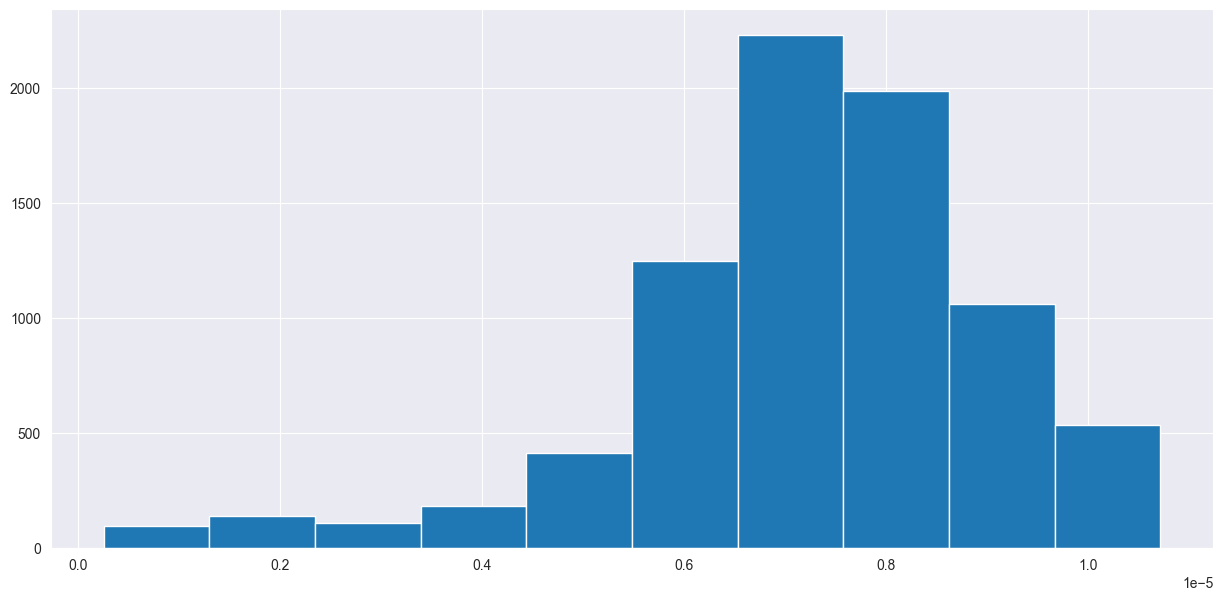

In [233]:
Z = np.max(newPoints)*.4
points = newPoints[newPoints < Z]
holder = []
for p in points:
    holder += [list(newPoints).index(p)]
print(y[holder[5]])
print(holder)
plt.hist(newPoints)
plt.show()

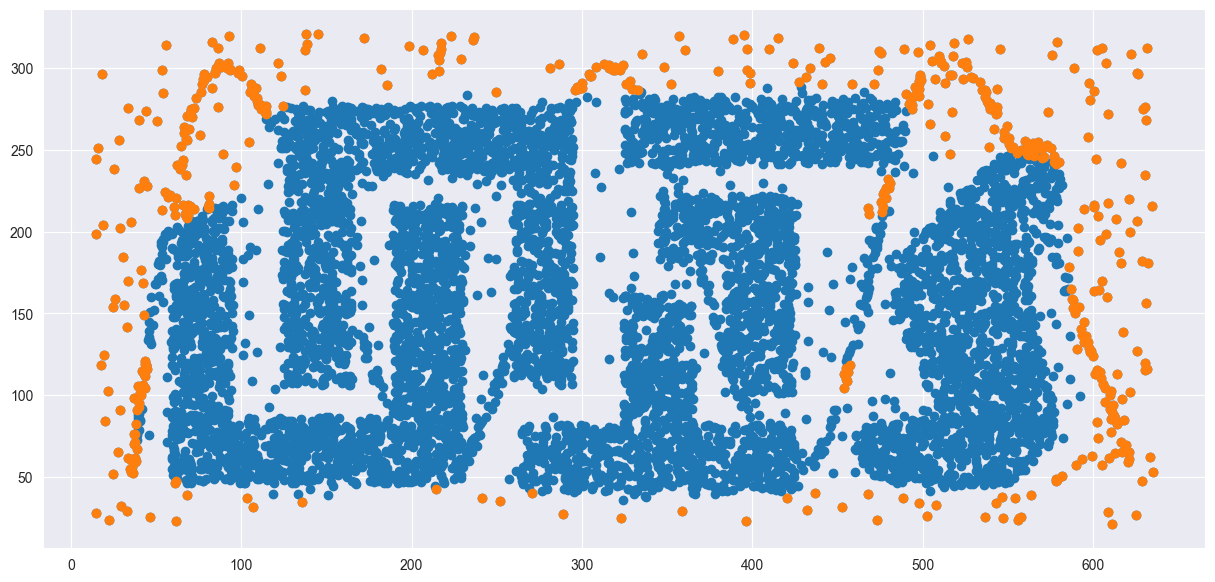

In [234]:
holderVals = []
for tm in holder:
    holderVals += [X[tm]]

holderVals = np.array(holderVals)
plt.scatter(X[:,0],X[:,1])
plt.scatter(holderVals[:,0],holderVals[:,1])
plt.show()